<a href="https://colab.research.google.com/github/artemkavara/Deep-Learning-KPI/blob/main/Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторна робота №3

Кавара Артем, КА-81

## Імпорти, поділ на тренувальну та тестувальну вибірку, зменшення кількості класів для тренування

### Імпорти

In [ ]:
import os
import tarfile
import shutil
import random

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
import pandas as pd

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import regularizers,constraints

In [ ]:
from tqdm import tqdm

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

### Завантаження файлів

In [ ]:
tar_source = "/content/drive/MyDrive/kkanji.tar"
tar_ref = tarfile.TarFile(tar_source, 'r')
tar_ref.extractall('/tmp')
tar_ref.close()

In [ ]:
image_source = "/tmp/kkanji2"
image_classes = os.listdir(image_source)

In [ ]:
with open("/content/drive/MyDrive/clusters.txt", "r") as f:
  clusters_final = f.readline()

In [ ]:
clusters_final = eval(clusters_final)

In [ ]:
clusters_final

### Створення відповідних директорій

In [ ]:
os.mkdir("/tmp/new_kkanji")

for i in range(50):
  os.mkdir(f"/tmp/new_kkanji/{i}")

for cl in clusters_final.keys():
  source_dir = image_source+"/"+cl
  for file in os.listdir(source_dir):
    shutil.copyfile(source_dir+"/"+file, f"/tmp/new_kkanji/{clusters_final[cl]}/{file}")

### Поділ на тренувальну та тестову вибірки

In [ ]:
'''shutil.rmtree('/tmp/train_50')
shutil.rmtree('/tmp/test_50')
shutil.rmtree('/tmp/valid_50')'''

"shutil.rmtree('/tmp/train_50')\nshutil.rmtree('/tmp/test_50')\nshutil.rmtree('/tmp/valid_50')"

In [ ]:
if not os.path.isdir("/tmp/train_50"):
     os.mkdir("/tmp/train_50")
if not os.path.isdir("/tmp/test_50"):
     os.mkdir("/tmp/test_50")
if not os.path.isdir("/tmp/valid_50"):
     os.mkdir("/tmp/valid_50")

In [ ]:
for folder in os.listdir("/tmp/new_kkanji"):

  dir = "/tmp/new_kkanji"+"/"+folder
  sample = os.listdir(dir)
  sample = np.array(sample)
  np.random.shuffle(sample)
  train_sample, valid_sample, test_sample = np.split(sample, [int(0.7*len(sample)), int(0.9*len(sample))])
  
  os.mkdir(f"/tmp/train_50/{folder}")
  os.mkdir(f"/tmp/valid_50/{folder}")
  os.mkdir(f"/tmp/test_50/{folder}")

  for (i, train) in enumerate(train_sample):
      
      shutil.copyfile(dir+"/"+train, f"/tmp/train_50/{folder}/{train}")
      os.rename(f"/tmp/train_50/{folder}/{train}", 
                f"/tmp/train_50/{folder}/{folder}_{i}.png")


  for (j, valid) in enumerate(valid_sample):

      shutil.copyfile(dir+"/"+valid, f"/tmp/valid_50/{folder}/{valid}")
      os.rename(f"/tmp/valid_50/{folder}/{valid}", 
                f"/tmp/valid_50/{folder}/{folder}_{j}.png")
      
  for (k, test) in enumerate(test_sample):
    
      shutil.copyfile(dir+"/"+test, f"/tmp/test_50/{folder}/{test}")
      os.rename(f"/tmp/test_50/{folder}/{test}", 
                f"/tmp/test_50/{folder}/{folder}_{k}.png")
      

## Побудова власної згорткової мережі на меншій кількості вихідних класів

### Генерація поділу на валідаційну та тренувальну вибірки

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)

In [ ]:
def generate_train_valid_test(data_dir, batch_size, image_size = 64, i = "50", color = "grayscale"):
  train_data = datagen.flow_from_directory(
      data_dir+"/train" + i,
      (image_size, image_size),
      color,
      batch_size = batch_size,
  )

  valid_data = datagen.flow_from_directory(
      data_dir+"/valid" + i,
      (image_size, image_size),
      color,
      batch_size = batch_size,
  )

  test_data = datagen.flow_from_directory(
      data_dir+"/test" + i,
      (image_size, image_size),
      color,
      batch_size = batch_size,
  )
  return train_data, valid_data, test_data

In [ ]:
train_data, valid_data, test_data = generate_train_valid_test("/tmp", 64)

Found 98277 images belonging to 50 classes.
Found 28081 images belonging to 50 classes.
Found 14066 images belonging to 50 classes.


### Візуалізація

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
def plot_res(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, label = "Train")
  plt.plot(epochs, val_acc, label = "Validation")
  plt.title('Training and validation accuracy')

  plt.figure()

  plt.plot(epochs, loss, label = "Train")
  plt.plot(epochs, val_loss, label = "Validation")
  plt.title('Training and validation loss')
  plt.legend()

### Проста модель

In [ ]:
model_1 = tf.keras.Sequential([
  layers.Conv2D (32 , (3 , 3) , padding ='same', activation ='relu',
  input_shape =(64, 64, 1)),
  layers.MaxPooling2D ( pool_size =(2 , 2)),
  layers.Flatten(),
  layers.Dense(50, activation ='softmax')
])

model_1.compile(
  optimizer= tf.optimizers.Adam(),  
  loss="categorical_crossentropy",
  metrics=['accuracy'])

In [ ]:
with tf.device('/device:GPU:0'):
  history_1 = model_1.fit(
    train_data,
    validation_data=valid_data,
    epochs=10
  )

Epoch 1/10
1536/1536 [==============================] - 53s 34ms/step - loss: 2.0516 - accuracy: 0.4677 - val_loss: 1.5578 - val_accuracy: 0.5811
Epoch 2/10
1536/1536 [==============================] - 51s 33ms/step - loss: 1.2504 - accuracy: 0.6593 - val_loss: 1.5460 - val_accuracy: 0.5882
Epoch 3/10
1536/1536 [==============================] - 50s 33ms/step - loss: 0.9852 - accuracy: 0.7280 - val_loss: 1.5988 - val_accuracy: 0.5847
Epoch 4/10
1536/1536 [==============================] - 50s 33ms/step - loss: 0.7684 - accuracy: 0.7877 - val_loss: 1.7113 - val_accuracy: 0.5747
Epoch 5/10
1536/1536 [==============================] - 50s 33ms/step - loss: 0.5714 - accuracy: 0.8440 - val_loss: 1.8681 - val_accuracy: 0.5655
Epoch 6/10
1536/1536 [==============================] - 50s 33ms/step - loss: 0.4130 - accuracy: 0.8892 - val_loss: 2.0786 - val_accuracy: 0.5603
Epoch 7/10
1536/1536 [==============================] - 50s 33ms/step - loss: 0.2869 - accuracy: 0.9259 - val_loss: 2.2966 -

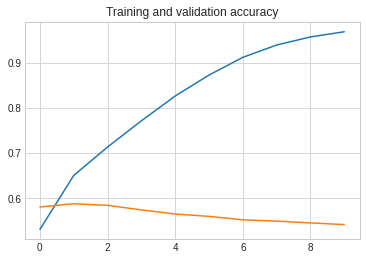

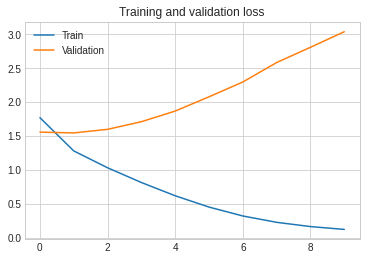

In [ ]:
plot_res(history_1)

### Вдосконалення моделі

#### Додавання ще одного шару

In [ ]:
model_2 = tf.keras.Sequential([
  layers.BatchNormalization (input_shape =(64 , 64 , 1)),
  layers.Conv2D (32 , (3 , 3) , padding ='same', activation ='relu'),
  layers.Conv2D (32 , (3 , 3) , padding ='same', activation ='relu'),
  layers.MaxPooling2D ( pool_size =(2 , 2)),
  layers.Flatten(),
  layers.Dense(50, activation ='softmax')
])

model_2.compile(
  optimizer= tf.optimizers.Adam(),  
  loss="categorical_crossentropy",
  metrics=['accuracy'],)

In [ ]:
with tf.device('/device:GPU:0'):
  history_2 = model_2.fit(
    train_data,
    validation_data=valid_data,
    epochs=10,
    callbacks = [callback]
  )

Epoch 1/10
1536/1536 [==============================] - 60s 39ms/step - loss: 1.9340 - accuracy: 0.4973 - val_loss: 1.3809 - val_accuracy: 0.6266
Epoch 2/10
1536/1536 [==============================] - 58s 38ms/step - loss: 1.0329 - accuracy: 0.7175 - val_loss: 1.3818 - val_accuracy: 0.6333
Epoch 3/10
1536/1536 [==============================] - 58s 38ms/step - loss: 0.5458 - accuracy: 0.8467 - val_loss: 1.6497 - val_accuracy: 0.6127
Epoch 4/10
1536/1536 [==============================] - 58s 38ms/step - loss: 0.2018 - accuracy: 0.9414 - val_loss: 2.4143 - val_accuracy: 0.5904


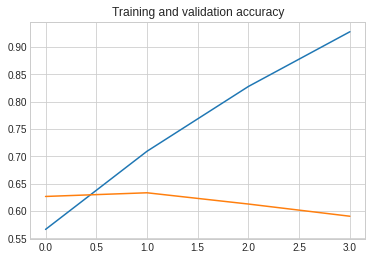

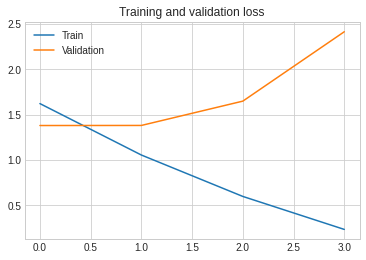

In [ ]:
plot_res(history_2)

#### Зміна параметрів

In [ ]:
model_3 = tf.keras.Sequential([
  layers.BatchNormalization (input_shape =(64 , 64 , 1)),
  layers.Conv2D (16 , (3 , 3) , padding ='same', activation ='relu'),
  layers.Conv2D (32 , (3 , 3) , padding ='same', activation ='relu'),
  layers.MaxPooling2D ( pool_size =(2 , 2)),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(50, activation ='softmax')
])

model_3.compile(
  optimizer= tf.optimizers.Adam(0.0005),  
  loss="categorical_crossentropy",
  metrics=['accuracy'],)

In [ ]:
with tf.device('/device:GPU:0'):
  history_3 = model_3.fit(
    train_data,
    validation_data=valid_data,
    epochs=10,
    callbacks = [callback]
  )

Epoch 1/10
1536/1536 [==============================] - 58s 37ms/step - loss: 2.0159 - accuracy: 0.4714 - val_loss: 1.4665 - val_accuracy: 0.6015
Epoch 2/10
1536/1536 [==============================] - 56s 36ms/step - loss: 1.2243 - accuracy: 0.6647 - val_loss: 1.4312 - val_accuracy: 0.6148
Epoch 3/10
1536/1536 [==============================] - 56s 36ms/step - loss: 0.9409 - accuracy: 0.7363 - val_loss: 1.4282 - val_accuracy: 0.6198
Epoch 4/10
1536/1536 [==============================] - 56s 37ms/step - loss: 0.6950 - accuracy: 0.8029 - val_loss: 1.5417 - val_accuracy: 0.6148
Epoch 5/10
1536/1536 [==============================] - 56s 37ms/step - loss: 0.4936 - accuracy: 0.8546 - val_loss: 1.7219 - val_accuracy: 0.5999
Epoch 6/10
1536/1536 [==============================] - 56s 37ms/step - loss: 0.3548 - accuracy: 0.8909 - val_loss: 1.9857 - val_accuracy: 0.5964


#### Зміна параметрів v.2

In [ ]:
model_4 = tf.keras.Sequential([
  layers.BatchNormalization(input_shape =(64 , 64 , 1)),
  layers.Conv2D (16 , (4 , 4) , padding ='same', activation ='relu'),
  layers.Conv2D (32 , (4 , 4) , padding ='same', activation ='relu'),
  layers.MaxPooling2D ( pool_size =(2 , 2)),
  layers.Dropout(0.25),
  layers.Conv2D (32 , (4 , 4) , padding ='same', activation ='relu'),
  layers.MaxPooling2D ( pool_size =(2 , 2)),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(50, activation ='softmax')
])

model_4.compile(
  optimizer= tf.optimizers.Adagrad(),  
  loss="categorical_crossentropy",
  metrics=['accuracy'],)

In [ ]:
with tf.device('/device:GPU:0'):
  history_4 = model_4.fit(
    train_data,
    validation_data=valid_data,
    epochs=10,
    callbacks = [callback]
  )

Epoch 1/10
1536/1536 [==============================] - 67s 43ms/step - loss: 3.1245 - accuracy: 0.2184 - val_loss: 2.1684 - val_accuracy: 0.4379
Epoch 2/10
1536/1536 [==============================] - 65s 42ms/step - loss: 2.2191 - accuracy: 0.4146 - val_loss: 2.0599 - val_accuracy: 0.4650
Epoch 3/10
1536/1536 [==============================] - 65s 42ms/step - loss: 2.1185 - accuracy: 0.4362 - val_loss: 2.0004 - val_accuracy: 0.4783
Epoch 4/10
1536/1536 [==============================] - 65s 42ms/step - loss: 2.0470 - accuracy: 0.4558 - val_loss: 1.9601 - val_accuracy: 0.4901
Epoch 5/10
1536/1536 [==============================] - 65s 42ms/step - loss: 2.0052 - accuracy: 0.4660 - val_loss: 1.9165 - val_accuracy: 0.4981
Epoch 6/10
1536/1536 [==============================] - 65s 42ms/step - loss: 1.9535 - accuracy: 0.4811 - val_loss: 1.8782 - val_accuracy: 0.5088
Epoch 7/10
1536/1536 [==============================] - 65s 42ms/step - loss: 1.8930 - accuracy: 0.4953 - val_loss: 1.8434 -

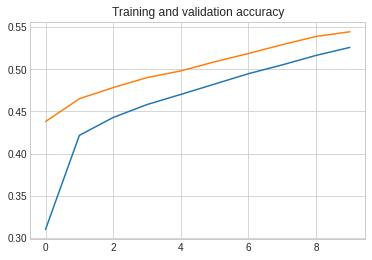

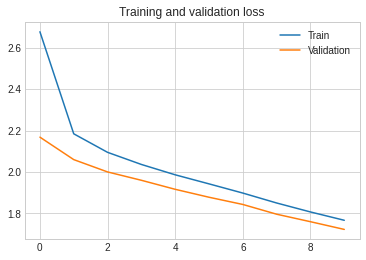

In [ ]:
plot_res(history_4)

#### Додавання ще 2 шарів та оптимізатор `Аdamax`

In [ ]:
model_4 = tf.keras.Sequential([
  layers.BatchNormalization (input_shape =(64 , 64 , 1)),
  layers.Conv2D (32, (3 , 3) , padding ='same', activation ='relu'),
  layers.Conv2D (32 , (3 , 3) , padding ='same', activation ='relu'),
  layers.MaxPooling2D ( pool_size =(2 , 2)),
  layers.Dropout(0.25),
  layers.BatchNormalization (),
  layers.Conv2D (64, (3 , 3) , padding ='same', activation ='relu'),
  layers.Conv2D (64 , (3 , 3) , padding ='same', activation ='relu'),
  layers.MaxPooling2D ( pool_size =(2 , 2)),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(50, activation ='softmax')
])

model_4.compile(
  optimizer= tf.optimizers.Adamax(),  
  loss="categorical_crossentropy",
  metrics=['accuracy'],)

In [ ]:
with tf.device('/device:GPU:0'):
  history_4 = model_4.fit(
    train_data,
    validation_data=valid_data,
    epochs=15,
    callbacks = [callback]
  )

Epoch 1/15
1536/1536 [==============================] - 78s 30ms/step - loss: 2.1755 - accuracy: 0.4387 - val_loss: 1.3620 - val_accuracy: 0.6274
Epoch 2/15
1536/1536 [==============================] - 45s 29ms/step - loss: 1.2799 - accuracy: 0.6498 - val_loss: 1.1731 - val_accuracy: 0.6853
Epoch 3/15
1536/1536 [==============================] - 45s 29ms/step - loss: 1.0260 - accuracy: 0.7159 - val_loss: 1.0968 - val_accuracy: 0.7037
Epoch 4/15
1536/1536 [==============================] - 45s 29ms/step - loss: 0.8586 - accuracy: 0.7593 - val_loss: 1.0617 - val_accuracy: 0.7146
Epoch 5/15
1536/1536 [==============================] - 44s 29ms/step - loss: 0.7188 - accuracy: 0.7951 - val_loss: 1.0769 - val_accuracy: 0.7180
Epoch 6/15
1536/1536 [==============================] - 45s 29ms/step - loss: 0.6216 - accuracy: 0.8200 - val_loss: 1.0741 - val_accuracy: 0.7235
Epoch 7/15
1536/1536 [==============================] - 45s 30ms/step - loss: 0.5357 - accuracy: 0.8429 - val_loss: 1.1286 -

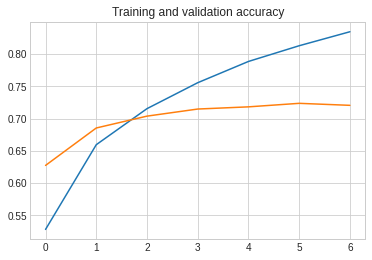

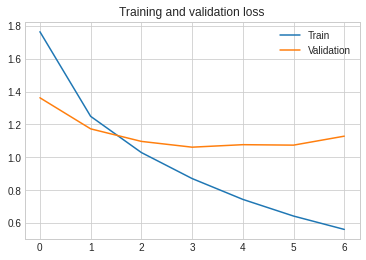

In [ ]:
plot_res(history_4)

#### Експерименти з параметрами (batch size) та функціями активації

In [ ]:
model_5 = tf.keras.Sequential([
  layers.BatchNormalization (input_shape =(64 , 64 , 1)),
  layers.Conv2D (32, (6 , 6) , padding ='same', activation =layers.LeakyReLU()),
  layers.Conv2D (32 , (6 , 6) , padding ='same', activation =layers.LeakyReLU()),
  layers.MaxPooling2D ( pool_size =(4 , 4)),
  layers.Dropout(0.25),
  layers.BatchNormalization (),
  layers.Conv2D (64, (3 , 3) , padding ='same', activation ='relu'),
  layers.Conv2D (64 , (3 , 3) , padding ='same', activation ='relu'),
  layers.MaxPooling2D ( pool_size =(2 , 2)),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(50, activation ='softmax')
])

model_5.compile(
  optimizer= tf.optimizers.Adamax(),  
  loss="categorical_crossentropy",
  metrics=['accuracy', tf.keras.metrics.AUC()],)

In [ ]:
with tf.device('/device:GPU:0'):
  history_5 = model_5.fit(
    train_data,
    validation_data=valid_data,
    epochs=15,
    callbacks = [callback]
  )

Epoch 1/15
1536/1536 [==============================] - 64s 41ms/step - loss: 2.1903 - accuracy: 0.4169 - auc: 0.9086 - val_loss: 1.3217 - val_accuracy: 0.6361 - val_auc: 0.9662
Epoch 2/15
1536/1536 [==============================] - 62s 41ms/step - loss: 1.3220 - accuracy: 0.6370 - auc: 0.9658 - val_loss: 1.1265 - val_accuracy: 0.6898 - val_auc: 0.9729
Epoch 3/15
1536/1536 [==============================] - 63s 41ms/step - loss: 1.1088 - accuracy: 0.6923 - auc: 0.9744 - val_loss: 1.0460 - val_accuracy: 0.7130 - val_auc: 0.9740
Epoch 4/15
1536/1536 [==============================] - 63s 41ms/step - loss: 0.9912 - accuracy: 0.7249 - auc: 0.9779 - val_loss: 0.9751 - val_accuracy: 0.7354 - val_auc: 0.9760
Epoch 5/15
1536/1536 [==============================] - 63s 41ms/step - loss: 0.9016 - accuracy: 0.7472 - auc: 0.9809 - val_loss: 0.9245 - val_accuracy: 0.7459 - val_auc: 0.9785
Epoch 6/15
1536/1536 [==============================] - 63s 41ms/step - loss: 0.8421 - accuracy: 0.7623 - auc:

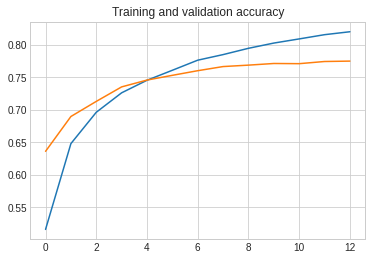

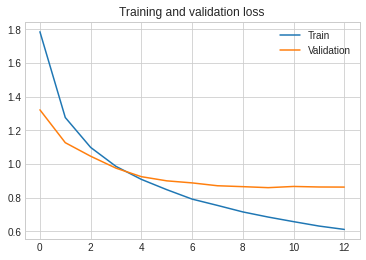

In [ ]:
plot_res(history_5)

#### Подальші експерименти з гіперпараметрами та `valid` padding

In [ ]:
model_6 = tf.keras.Sequential([
  layers.BatchNormalization (input_shape =(64 , 64 , 1)),
  layers.Conv2D (16, (4 , 4) , padding ='valid', activation =layers.LeakyReLU()),
  layers.Conv2D (16 , (4 , 4) , padding ='valid', activation =layers.LeakyReLU()),
  layers.MaxPooling2D ( pool_size =(3 , 3)),
  layers.Dropout(0.25),
  layers.BatchNormalization (),
  layers.Conv2D (32, (4 , 4) , padding ='valid', activation =layers.LeakyReLU()),
  layers.Conv2D (32 , (4 , 4) , padding ='valid', activation =layers.LeakyReLU()),
  layers.MaxPooling2D ( pool_size =(3 , 3)),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(50, activation ='softmax')
])

model_6.compile(
  optimizer= tf.optimizers.Adamax(),  
  loss="categorical_crossentropy",
  metrics=['accuracy', tf.keras.metrics.AUC()],)

In [ ]:
with tf.device('/device:GPU:0'):
  history_6 = model_6.fit(
    train_data,
    validation_data=valid_data,
    epochs=15,
    callbacks = [callback]
  )

Epoch 1/15
1536/1536 [==============================] - 40s 26ms/step - loss: 2.8651 - accuracy: 0.2575 - auc_1: 0.8405 - val_loss: 1.8474 - val_accuracy: 0.5030 - val_auc_1: 0.9448
Epoch 2/15
1536/1536 [==============================] - 39s 26ms/step - loss: 1.9059 - accuracy: 0.4818 - auc_1: 0.9371 - val_loss: 1.5809 - val_accuracy: 0.5714 - val_auc_1: 0.9557
Epoch 3/15
1536/1536 [==============================] - 40s 26ms/step - loss: 1.6860 - accuracy: 0.5406 - auc_1: 0.9487 - val_loss: 1.4596 - val_accuracy: 0.6039 - val_auc_1: 0.9614
Epoch 4/15
1536/1536 [==============================] - 40s 26ms/step - loss: 1.5651 - accuracy: 0.5728 - auc_1: 0.9549 - val_loss: 1.3881 - val_accuracy: 0.6216 - val_auc_1: 0.9639
Epoch 5/15
1536/1536 [==============================] - 39s 26ms/step - loss: 1.4950 - accuracy: 0.5891 - auc_1: 0.9585 - val_loss: 1.3285 - val_accuracy: 0.6410 - val_auc_1: 0.9673
Epoch 6/15
1536/1536 [==============================] - 40s 26ms/step - loss: 1.4349 - acc

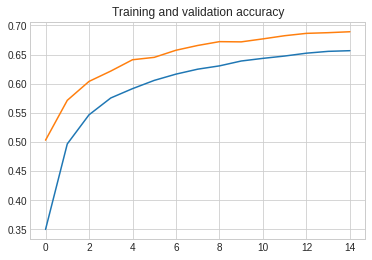

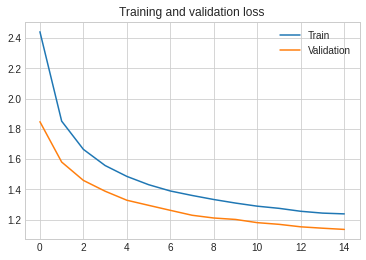

In [ ]:
plot_res(history_6)

#### Ще один шар

In [ ]:
model_7 = tf.keras.Sequential([
  layers.BatchNormalization (input_shape =(64 , 64 , 1)),
  layers.Conv2D (16, (4 , 4) , padding ='same', activation =layers.LeakyReLU()),
  layers.Conv2D (16 , (4 , 4) , padding ='same', activation =layers.LeakyReLU()),
  layers.MaxPooling2D ( pool_size =(3 , 3)),
  layers.Dropout(0.25),
  layers.BatchNormalization (),
  layers.Conv2D (32, (4 , 4) , padding ='same', activation =layers.LeakyReLU()),
  layers.Conv2D (32 , (4 , 4) , padding ='same', activation =layers.LeakyReLU()),
  layers.MaxPooling2D ( pool_size =(3 , 3)),
  layers.Dropout(0.25),
  layers.BatchNormalization (),
  layers.Conv2D (64, (4 , 4) , padding ='same', activation =layers.LeakyReLU()),
  layers.Conv2D (64 , (4 , 4) , padding ='same', activation =layers.LeakyReLU()),
  layers.MaxPooling2D ( pool_size =(3 , 3)),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(50, activation ='softmax')
])

model_7.compile(
  optimizer= tf.optimizers.Adamax(),  
  loss="categorical_crossentropy",
  metrics=['accuracy', tf.keras.metrics.AUC()],)

In [ ]:
with tf.device('/device:GPU:0'):
  history_7 = model_7.fit(
    train_data,
    validation_data=valid_data,
    epochs=15,
    callbacks = [callback]
  )

Epoch 1/15
1536/1536 [==============================] - 48s 31ms/step - loss: 2.6514 - accuracy: 0.3049 - auc_3: 0.8652 - val_loss: 1.4893 - val_accuracy: 0.5897 - val_auc_3: 0.9603
Epoch 2/15
1536/1536 [==============================] - 46s 30ms/step - loss: 1.6308 - accuracy: 0.5517 - auc_3: 0.9530 - val_loss: 1.2626 - val_accuracy: 0.6512 - val_auc_3: 0.9704
Epoch 3/15
1536/1536 [==============================] - 46s 30ms/step - loss: 1.3943 - accuracy: 0.6113 - auc_3: 0.9638 - val_loss: 1.1328 - val_accuracy: 0.6872 - val_auc_3: 0.9738
Epoch 4/15
1536/1536 [==============================] - 47s 31ms/step - loss: 1.2684 - accuracy: 0.6457 - auc_3: 0.9691 - val_loss: 1.0484 - val_accuracy: 0.7095 - val_auc_3: 0.9770
Epoch 5/15
1536/1536 [==============================] - 47s 30ms/step - loss: 1.1905 - accuracy: 0.6662 - auc_3: 0.9721 - val_loss: 1.0085 - val_accuracy: 0.7186 - val_auc_3: 0.9784
Epoch 6/15
1536/1536 [==============================] - 46s 30ms/step - loss: 1.1317 - acc

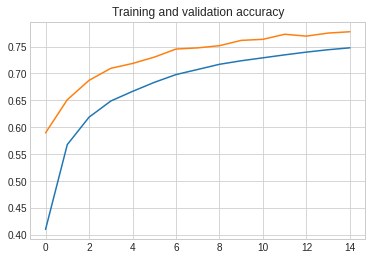

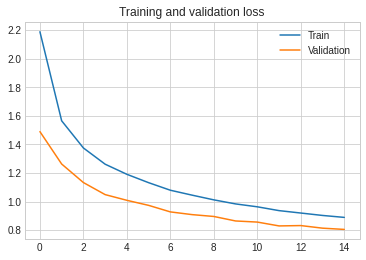

In [ ]:
plot_res(history_7)

## Навчання на справжніх даних

### Поділ на вибірки та генерація потоку даних для навчання мереж

In [ ]:
#shutil.rmtree('/tmp/train_50')
#shutil.rmtree('/tmp/test_50')
#shutil.rmtree('/tmp/valid_50')

In [ ]:
if not os.path.isdir("/tmp/train"):
     os.mkdir("/tmp/train")
if not os.path.isdir("/tmp/test"):
     os.mkdir("/tmp/test")
if not os.path.isdir("/tmp/valid"):
     os.mkdir("/tmp/valid")

In [ ]:
for folder in os.listdir("/tmp/kkanji2"):

  dir = "/tmp/kkanji2"+"/"+folder
  sample = os.listdir(dir)
  sample = np.array(sample)
  np.random.shuffle(sample)
  train_sample, valid_sample, test_sample = np.split(sample, [int(0.8*len(sample)), int(0.9*len(sample))])
  
  os.mkdir(f"/tmp/train/{folder}")
  os.mkdir(f"/tmp/valid/{folder}")
  os.mkdir(f"/tmp/test/{folder}")

  for (i, train) in enumerate(train_sample):
      
      shutil.copyfile(dir+"/"+train, f"/tmp/train/{folder}/{train}")
      os.rename(f"/tmp/train/{folder}/{train}", 
                f"/tmp/train/{folder}/{folder}_{i}.png")


  for (j, valid) in enumerate(valid_sample):

      shutil.copyfile(dir+"/"+valid, f"/tmp/valid/{folder}/{valid}")
      os.rename(f"/tmp/valid/{folder}/{valid}", 
                f"/tmp/valid/{folder}/{folder}_{j}.png")
      
  for (k, test) in enumerate(test_sample):
    
      shutil.copyfile(dir+"/"+test, f"/tmp/test/{folder}/{test}")
      os.rename(f"/tmp/test/{folder}/{test}", 
                f"/tmp/test/{folder}/{folder}_{k}.png")
      

In [ ]:
train_data, valid_data, test_data = generate_train_valid_test("/tmp", 64, 0)

Found 110449 images belonging to 3832 classes.
Found 13648 images belonging to 3832 classes.
Found 16327 images belonging to 3832 classes.


### Остання модель з попереднього пункту

In [ ]:
model_7 = tf.keras.Sequential([
  layers.BatchNormalization (input_shape =(64 , 64 , 1)),
  layers.Conv2D (16, (4 , 4) , padding ='same', activation =layers.LeakyReLU()),
  layers.Conv2D (16 , (4 , 4) , padding ='same', activation =layers.LeakyReLU()),
  layers.MaxPooling2D ( pool_size =(3 , 3)),
  layers.Dropout(0.25),
  layers.BatchNormalization (),
  layers.Conv2D (32, (4 , 4) , padding ='same', activation =layers.LeakyReLU()),
  layers.Conv2D (32 , (4 , 4) , padding ='same', activation =layers.LeakyReLU()),
  layers.MaxPooling2D ( pool_size =(3 , 3)),
  layers.Dropout(0.25),
  layers.BatchNormalization (),
  layers.Conv2D (64, (4 , 4) , padding ='same', activation =layers.LeakyReLU()),
  layers.Conv2D (64 , (4 , 4) , padding ='same', activation =layers.LeakyReLU()),
  layers.MaxPooling2D ( pool_size =(3 , 3)),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(len(image_classes), activation ='softmax')
])

model_7.compile(
  optimizer= tf.optimizers.Adamax(),  
  loss="categorical_crossentropy",
  metrics=['accuracy', tf.keras.metrics.AUC()],)

In [ ]:
with tf.device('/device:GPU:0'):
  history_7 = model_7.fit(
    train_data,
    validation_data=valid_data,
    epochs=15,
    callbacks = [callback]
  )

Epoch 1/15
1726/1726 [==============================] - 116s 66ms/step - loss: 5.6831 - accuracy: 0.1753 - auc_5: 0.6937 - val_loss: 2.9083 - val_accuracy: 0.5195 - val_auc_5: 0.8894
Epoch 2/15
1726/1726 [==============================] - 114s 66ms/step - loss: 2.9902 - accuracy: 0.5032 - auc_5: 0.8881 - val_loss: 1.9510 - val_accuracy: 0.6534 - val_auc_5: 0.9333
Epoch 3/15
1726/1726 [==============================] - 114s 66ms/step - loss: 2.1544 - accuracy: 0.6171 - auc_5: 0.9287 - val_loss: 1.4372 - val_accuracy: 0.7369 - val_auc_5: 0.9572
Epoch 4/15
1726/1726 [==============================] - 114s 66ms/step - loss: 1.6877 - accuracy: 0.6860 - auc_5: 0.9480 - val_loss: 1.2314 - val_accuracy: 0.7633 - val_auc_5: 0.9608
Epoch 5/15
1726/1726 [==============================] - 114s 66ms/step - loss: 1.3950 - accuracy: 0.7300 - auc_5: 0.9588 - val_loss: 1.0862 - val_accuracy: 0.7829 - val_auc_5: 0.9685
Epoch 6/15
1726/1726 [==============================] - 113s 66ms/step - loss: 1.1952

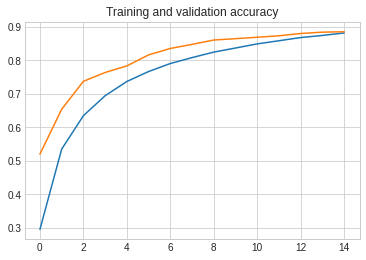

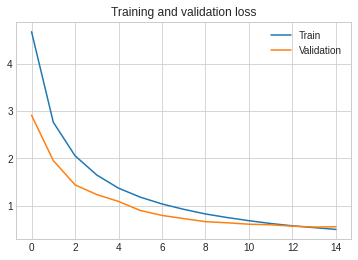

In [ ]:
plot_res(history_7)

In [ ]:
model_7.evaluate(test_data)

256/256 [==============================] - 12s 47ms/step - loss: 2.0131 - accuracy: 0.7823 - auc_5: 0.9393


[2.013117551803589, 0.7822625041007996, 0.9393393993377686]

### Подальші вдосконалення моделі

#### Додавання одного шару Dense

In [ ]:
model_7.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_16 (Batc (None, 64, 64, 1)         4         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 64, 64, 16)        272       
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 64, 64, 16)        4112      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 21, 21, 16)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 21, 21, 16)        0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 21, 21, 16)        64        
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 21, 21, 32)       

In [ ]:
model_8 = tf.keras.Sequential([
  layers.BatchNormalization (input_shape =(64 , 64 , 1)),
  layers.Conv2D (16, (4 , 4) , padding ='same', activation =layers.LeakyReLU()),
  layers.Conv2D (16 , (4 , 4) , padding ='same', activation =layers.LeakyReLU()),
  layers.MaxPooling2D ( pool_size =(3 , 3)),
  layers.Dropout(0.25),

  layers.BatchNormalization (),
  layers.Conv2D (32, (4 , 4) , padding ='same', activation =layers.LeakyReLU()),
  layers.Conv2D (32 , (4 , 4) , padding ='same', activation =layers.LeakyReLU()),
  layers.MaxPooling2D ( pool_size =(3 , 3)),
  layers.Dropout(0.25),

  layers.BatchNormalization (),
  layers.Conv2D (64, (4 , 4) , padding ='same', activation =layers.LeakyReLU()),
  layers.Conv2D (64 , (4 , 4) , padding ='same', activation =layers.LeakyReLU()),
  layers.MaxPooling2D ( pool_size =(3 , 3)),
  layers.Dropout(0.25),

  layers.Flatten(),

  layers.Dense(256, activation =layers.LeakyReLU()),
  layers.Dropout(0.5),
  layers.Dense(len(image_classes), activation ='softmax')
])

model_8.compile(
  optimizer= tf.optimizers.Adamax(),  
  loss="categorical_crossentropy",
  metrics=['accuracy', tf.keras.metrics.AUC()],)

In [ ]:
with tf.device('/device:GPU:0'):
  history_8 = model_8.fit(
    train_data,
    validation_data=valid_data,
    epochs=15,
    callbacks = [callback]
  )

Epoch 1/15
1726/1726 [==============================] - 116s 67ms/step - loss: 6.1776 - accuracy: 0.1093 - auc_6: 0.6517 - val_loss: 3.7468 - val_accuracy: 0.4039 - val_auc_6: 0.8292
Epoch 2/15
1726/1726 [==============================] - 116s 67ms/step - loss: 4.0413 - accuracy: 0.3637 - auc_6: 0.8223 - val_loss: 2.6251 - val_accuracy: 0.5601 - val_auc_6: 0.8998
Epoch 3/15
1726/1726 [==============================] - 115s 67ms/step - loss: 3.1840 - accuracy: 0.4735 - auc_6: 0.8771 - val_loss: 2.0792 - val_accuracy: 0.6498 - val_auc_6: 0.9286
Epoch 4/15
1726/1726 [==============================] - 116s 67ms/step - loss: 2.6909 - accuracy: 0.5415 - auc_6: 0.9036 - val_loss: 1.7128 - val_accuracy: 0.6953 - val_auc_6: 0.9443
Epoch 5/15
1726/1726 [==============================] - 115s 66ms/step - loss: 2.3528 - accuracy: 0.5841 - auc_6: 0.9201 - val_loss: 1.4830 - val_accuracy: 0.7282 - val_auc_6: 0.9545
Epoch 6/15
1726/1726 [==============================] - 114s 66ms/step - loss: 2.1083

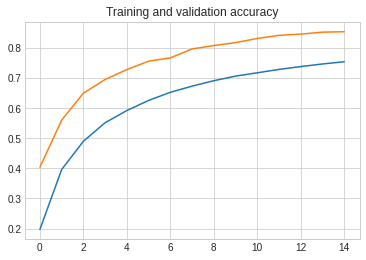

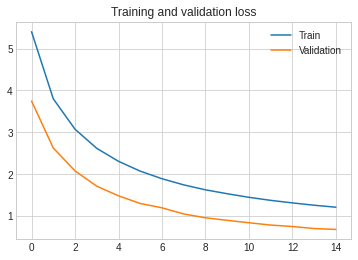

In [ ]:
plot_res(history_8)

In [ ]:
model_8.evaluate(test_data)

256/256 [==============================] - 12s 47ms/step - loss: 2.1140 - accuracy: 0.7479 - auc_6: 0.9292


[2.1139917373657227, 0.7479022741317749, 0.9292305111885071]

Результати можуть бути покращені

#### Встановлення нового значення для MaxPoolling

In [ ]:
model_9 = tf.keras.Sequential([
  layers.BatchNormalization (input_shape =(64 , 64 , 1)),
  layers.Conv2D (16, (4 , 4) , padding ='same', activation =layers.LeakyReLU()),
  layers.Conv2D (16 , (4 , 4) , padding ='same', activation =layers.LeakyReLU()),
  layers.MaxPooling2D ( pool_size =(2 , 2)),
  layers.Dropout(0.25),

  layers.BatchNormalization (),
  layers.Conv2D (32, (4 , 4) , padding ='same', activation =layers.LeakyReLU()),
  layers.Conv2D (32 , (4 , 4) , padding ='same', activation =layers.LeakyReLU()),
  layers.MaxPooling2D ( pool_size =(2 , 2)),
  layers.Dropout(0.25),

  layers.BatchNormalization (),
  layers.Conv2D (64, (4 , 4) , padding ='same', activation =layers.LeakyReLU()),
  layers.Conv2D (64 , (4 , 4) , padding ='same', activation =layers.LeakyReLU()),
  layers.MaxPooling2D ( pool_size =(2 , 2)),
  layers.Dropout(0.25),

  layers.Flatten(),

  layers.Dense(4096, activation =layers.LeakyReLU()),
  layers.Dropout(0.5),
  layers.Dense(len(image_classes), activation ='softmax')
])

model_9.compile(
  optimizer= tf.optimizers.Adamax(),  
  loss="categorical_crossentropy",
  metrics=['accuracy', tf.keras.metrics.AUC()],)

In [ ]:
with tf.device('/device:GPU:0'):
  history_9 = model_9.fit(
    train_data,
    validation_data=valid_data,
    epochs=24,
    callbacks = [callback]
  )

Epoch 1/24
1726/1726 [==============================] - 155s 89ms/step - loss: 3.9379 - accuracy: 0.4252 - auc_7: 0.8187 - val_loss: 1.1447 - val_accuracy: 0.7806 - val_auc_7: 0.9639
Epoch 2/24
1726/1726 [==============================] - 154s 89ms/step - loss: 1.2119 - accuracy: 0.7721 - auc_7: 0.9617 - val_loss: 0.7308 - val_accuracy: 0.8501 - val_auc_7: 0.9789
Epoch 3/24
1726/1726 [==============================] - 154s 89ms/step - loss: 0.6741 - accuracy: 0.8530 - auc_7: 0.9830 - val_loss: 0.6082 - val_accuracy: 0.8740 - val_auc_7: 0.9825
Epoch 4/24
1726/1726 [==============================] - 154s 89ms/step - loss: 0.4075 - accuracy: 0.9018 - auc_7: 0.9915 - val_loss: 0.5782 - val_accuracy: 0.8846 - val_auc_7: 0.9826
Epoch 5/24
1726/1726 [==============================] - 154s 89ms/step - loss: 0.2847 - accuracy: 0.9273 - auc_7: 0.9947 - val_loss: 0.6192 - val_accuracy: 0.8802 - val_auc_7: 0.9799
Epoch 6/24
1726/1726 [==============================] - 153s 89ms/step - loss: 0.2043

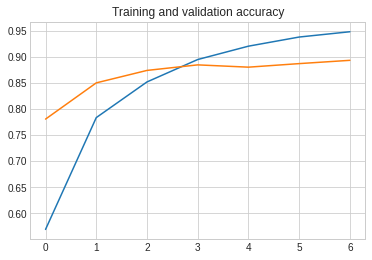

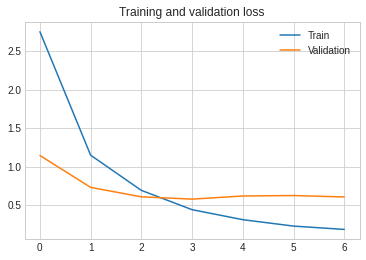

In [ ]:
plot_res(history_9)

In [ ]:
model_9.evaluate(test_data)

256/256 [==============================] - 13s 50ms/step - loss: 2.1432 - accuracy: 0.7933 - auc_7: 0.9345


[2.1431519985198975, 0.7933484315872192, 0.9344703555107117]

#### Боротьба з оверфітингом

In [ ]:
model_10 = tf.keras.Sequential([
  layers.BatchNormalization (input_shape =(64 , 64 , 1)),
  layers.Conv2D (32, (4 , 4) , padding ='same', activation =layers.LeakyReLU()),
  layers.Conv2D (32 , (4 , 4) , padding ='same', activation =layers.LeakyReLU()),
  layers.MaxPooling2D ( pool_size =(2 , 2)),
  layers.Dropout(0.25),

  layers.BatchNormalization (),
  layers.Conv2D (64, (4 , 4) , padding ='same', activation =layers.LeakyReLU()),
  layers.Conv2D (64 , (4 , 4) , padding ='same', activation =layers.LeakyReLU()),
  layers.MaxPooling2D ( pool_size =(2 , 2)),
  layers.Dropout(0.25),

  layers.BatchNormalization (),
  layers.Conv2D (64, (4 , 4) , padding ='same', activation =layers.LeakyReLU()),
  layers.Conv2D (64 , (4 , 4) , padding ='same', activation =layers.LeakyReLU()),
  layers.MaxPooling2D ( pool_size =(2 , 2)),
  layers.Dropout(0.25),

  layers.Flatten(),
  layers.BatchNormalization (),
  layers.Dense(4096, activation =layers.LeakyReLU()),
  layers.Dropout(0.75),
  layers.Dense(len(image_classes), activation ='softmax')
])

model_10.compile(
  optimizer= tf.optimizers.Adamax(),  
  loss="categorical_crossentropy",
  metrics=['accuracy', tf.keras.metrics.AUC()],)

In [ ]:
with tf.device('/device:GPU:0'):
  history_10 = model_10.fit(
    train_data,
    validation_data=valid_data,
    epochs=24,
    callbacks = [callback]
  )

Epoch 1/24
1726/1726 [==============================] - 195s 112ms/step - loss: 5.0913 - accuracy: 0.3153 - auc_8: 0.7682 - val_loss: 1.6400 - val_accuracy: 0.7157 - val_auc_8: 0.9353
Epoch 2/24
1726/1726 [==============================] - 193s 112ms/step - loss: 2.1185 - accuracy: 0.6441 - auc_8: 0.9204 - val_loss: 1.0367 - val_accuracy: 0.8028 - val_auc_8: 0.9649
Epoch 3/24
1726/1726 [==============================] - 193s 112ms/step - loss: 1.4519 - accuracy: 0.7330 - auc_8: 0.9502 - val_loss: 0.7793 - val_accuracy: 0.8472 - val_auc_8: 0.9765
Epoch 4/24
1726/1726 [==============================] - 194s 112ms/step - loss: 1.0790 - accuracy: 0.7864 - auc_8: 0.9658 - val_loss: 0.6650 - val_accuracy: 0.8690 - val_auc_8: 0.9794
Epoch 5/24
1726/1726 [==============================] - 193s 112ms/step - loss: 0.8414 - accuracy: 0.8227 - auc_8: 0.9754 - val_loss: 0.5928 - val_accuracy: 0.8760 - val_auc_8: 0.9829
Epoch 6/24
1726/1726 [==============================] - 193s 112ms/step - loss: 

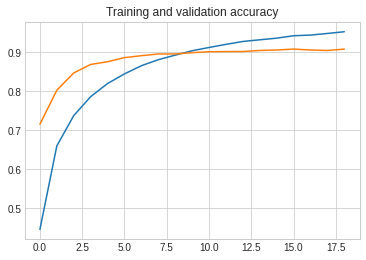

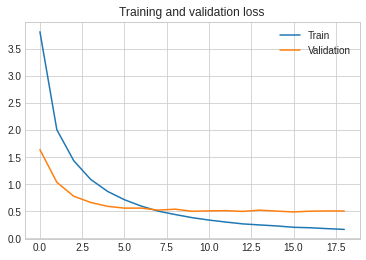

In [ ]:
plot_res(history_10)

In [ ]:
model_10.evaluate(test_data)

256/256 [==============================] - 15s 58ms/step - loss: 2.0196 - accuracy: 0.8032 - auc_8: 0.9361


[2.019634246826172, 0.8032094240188599, 0.9360683560371399]

#### Ще деякі модифікації

In [ ]:
model_11 = tf.keras.Sequential([
  layers.BatchNormalization (input_shape =(64 , 64 , 1)),
  layers.Conv2D (32, (4 , 4) , padding ='same', activation =layers.LeakyReLU()),
  layers.Conv2D (32 , (4 , 4) , padding ='same', activation =layers.LeakyReLU()),
  layers.MaxPooling2D ( pool_size =(4 , 4)),
  layers.Dropout(0.25),

  layers.BatchNormalization (),
  layers.Conv2D (64, (4 , 4) , padding ='same', activation =layers.LeakyReLU()),
  layers.Conv2D (64 , (4 , 4) , padding ='same', activation =layers.LeakyReLU()),
  layers.MaxPooling2D ( pool_size =(4 , 4)),
  layers.Dropout(0.25),

  layers.BatchNormalization (),
  layers.Conv2D (128, (4 , 4) , padding ='same', activation =layers.LeakyReLU()),
  layers.Conv2D (128 , (4 , 4) , padding ='same', activation =layers.LeakyReLU()),
  layers.MaxPooling2D ( pool_size =(2 , 2)),
  layers.Dropout(0.25),
  
  layers.Conv2D (128, (4 , 4) , padding ='same', activation =layers.LeakyReLU()),
  layers.MaxPooling2D ( pool_size =(2 , 2)),
  layers.Dropout(0.25),

  layers.Flatten(),
  layers.BatchNormalization (),
  layers.Dense(128, activation =layers.LeakyReLU()),
  layers.Dropout(0.5),
  layers.Dense(len(image_classes), activation ='softmax')
])

model_11.compile(
  optimizer= tf.optimizers.Adamax(),  
  loss="categorical_crossentropy",
  metrics=['accuracy', tf.keras.metrics.AUC()],)

In [ ]:
with tf.device('/device:GPU:0'):
  history_11 = model_11.fit(
    train_data,
    validation_data=valid_data,
    epochs=24,
    callbacks = [callback]
  )

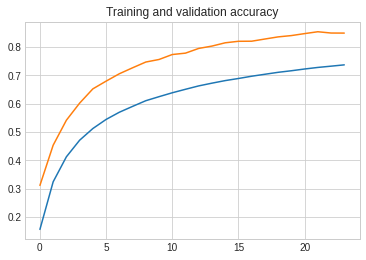

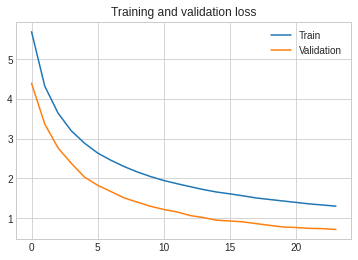

In [ ]:
plot_res(history_11)

In [ ]:
model_11.evaluate(test_data)

256/256 [==============================] - 13s 52ms/step - loss: 2.1974 - accuracy: 0.7617 - auc_10: 0.9328


[2.197392702102661, 0.7616831064224243, 0.9328147172927856]

### Найкраща модель

In [ ]:
import random

In [ ]:
def predict_images():
  sample_classes = random.sample(image_classes, 10)
  print(sample_classes)
  pred = []
  for sample in sample_classes:
    img_to_pred = random.sample(os.listdir(f"/tmp/test/{sample}"), 1)
    img = load_img(f"/tmp/test/{sample}/{img_to_pred[0]}", target_size=(64, 64), color_mode="grayscale") 
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    x /= 255  
    pred_0 = model_10.predict(x)
    pred.append(sorted(image_classes)[np.argmax(pred_0)])
  print(pred)

In [ ]:
predict_images()

['U+96C4', 'U+95C7', 'U+9DC3', 'U+59D3', 'U+68E0', 'U+63EE', 'U+984B', 'U+5408', 'U+69B4', 'U+537F']
['U+96C4', 'U+95A2', 'U+9D28', 'U+59D3', 'U+68E0', 'U+62BC', 'U+91CE', 'U+5408', 'U+676F', 'U+537F']


### Зберігання найкращої моделі

In [ ]:
!pip install -q pyyaml h5py

In [ ]:
!mkdir -p saved_model
model_10.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [ ]:
!zip -r /content/file.zip /content/saved_model

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/my_model/ (stored 0%)
  adding: content/saved_model/my_model/variables/ (stored 0%)
  adding: content/saved_model/my_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/saved_model/my_model/variables/variables.index (deflated 73%)
  adding: content/saved_model/my_model/saved_model.pb (deflated 90%)
  adding: content/saved_model/my_model/assets/ (stored 0%)


## Використання навченої моделі `Inception v3`

### Завантаження даних

In [ ]:
!wget https://data.deepai.org/FGVCAircraft.zip 

--2021-05-29 08:16:39--  https://data.deepai.org/FGVCAircraft.zip
Resolving data.deepai.org (data.deepai.org)... 138.201.36.183
Connecting to data.deepai.org (data.deepai.org)|138.201.36.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2754361826 (2.6G) [application/zip]
Saving to: ‘FGVCAircraft.zip.1’

FGVCAircraft.zip.1  100%[===================>]   2.56G  32.7MB/s    in 82s     

2021-05-29 08:18:02 (32.0 MB/s) - ‘FGVCAircraft.zip.1’ saved [2754361826/2754361826]



In [ ]:
import zipfile

In [ ]:
zip_source = "/content/FGVCAircraft.zip.1"
zip_ref = zipfile.ZipFile(zip_source, 'r')
zip_ref.extractall('/content')
zip_ref.close()

#### Створення sample

In [ ]:
import re

In [ ]:
train_images, train_labels = [], []

In [ ]:
with open("/content/fgvc-aircraft-2013b/data/images_manufacturer_train.txt", "r") as f:
  for line in f.readlines():
    temp_im, temp_lbl = re.match(r"\d+", line).group(0), line[8:-1]
    train_images.append(temp_im)
    train_labels.append(temp_lbl)

In [ ]:
valid_images, valid_labels = [], []
with open("/content/fgvc-aircraft-2013b/data/images_manufacturer_val.txt", "r") as f:
  for line in f.readlines():
    temp_im, temp_lbl = re.match(r"\d+", line).group(0), line[8:-1]
    valid_images.append(temp_im)
    valid_labels.append(temp_lbl)

In [ ]:
test_images, test_labels = [], []
with open("/content/fgvc-aircraft-2013b/data/images_manufacturer_test.txt", "r") as f:
  for line in f.readlines():
    temp_im, temp_lbl = re.match(r"\d+", line).group(0), line[8:-1]
    test_images.append(temp_im)
    test_labels.append(temp_lbl)

In [ ]:
!mkdir /content/train_air
!mkdir /content/valid_air
!mkdir /content/test_air

In [ ]:
for label in set(train_labels):
  os.mkdir(f"/content/train_air/{label}")

In [ ]:
for label in set(valid_labels):
  os.mkdir(f"/content/valid_air/{label}")

In [ ]:
for label in set(test_labels):
  os.mkdir(f"/content/test_air/{label}")

In [ ]:
for image, label in zip(train_images, train_labels):
  shutil.copy(f"/content/fgvc-aircraft-2013b/data/images/{image}.jpg", f"/content/train_air/{label}/{image}.jpg")

In [ ]:
for image, label in zip(test_images, test_labels):
  shutil.copy(f"/content/fgvc-aircraft-2013b/data/images/{image}.jpg", f"/content/test_air/{label}/{image}.jpg")

In [ ]:
for image, label in zip(valid_images, valid_labels):
  shutil.copy(f"/content/fgvc-aircraft-2013b/data/images/{image}.jpg", f"/content/valid_air/{label}/{image}.jpg")

### Генерація даних для мережі

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator()

In [ ]:
train_data, valid_data, test_data = generate_train_valid_test("/content", 64, 299, 
                                                              "_air", "rgb")

Found 3334 images belonging to 30 classes.
Found 3333 images belonging to 30 classes.
Found 3333 images belonging to 30 classes.


### Перевірка моделі

In [ ]:
InceptionV3 = tf.keras.applications.InceptionV3(include_top=True,weights="imagenet", classifier_activation="softmax")
decode = tf.keras.applications.inception_v3.decode_predictions
scaling = tf.keras.applications.inception_v3.preprocess_input

image_preprocessor = Sequential([
   layers.experimental.preprocessing.Resizing(299, 299),
   layers.Activation(scaling)
   ]
)

96116736/96112376 [==============================] - 1s 0us/step


In [ ]:
inception_layers = InceptionV3.layers
inception_layers.pop()
for layer in inception_layers:
    layer.trainable = False
logit = Sequential([tf.keras.layers.Dense(len(set(test_labels)), activation='softmax')])(inception_layers[-1].output)
model = tf.keras.Model(inputs=InceptionV3.inputs, outputs=logit)
pipeline = Sequential([tf.keras.layers.Activation(scaling),model])
#model.summary()

In [ ]:
pipeline.compile(optimizer='Adam',  loss = "categorical_crossentropy", metrics = ["accuracy", tf.metrics.AUC()])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
with tf.device('/device:GPU:0'):
  history = pipeline.fit(train_data, 
                         steps_per_epoch=len(train_data),
                         validation_data=valid_data, 
                         validation_steps=len(valid_data),
                         epochs=30, 
                         verbose=1,
                         callbacks = [callback])

Epoch 1/30
53/53 [==============================] - 108s 2s/step - loss: 2.6361 - accuracy: 0.2358 - auc: 0.8257 - val_loss: 2.3681 - val_accuracy: 0.2793 - val_auc: 0.8761
Epoch 2/30
53/53 [==============================] - 100s 2s/step - loss: 2.2479 - accuracy: 0.3110 - auc: 0.8919 - val_loss: 2.1830 - val_accuracy: 0.3165 - val_auc: 0.9007
Epoch 3/30
53/53 [==============================] - 100s 2s/step - loss: 2.0574 - accuracy: 0.3644 - auc: 0.9168 - val_loss: 2.0791 - val_accuracy: 0.3597 - val_auc: 0.9097
Epoch 4/30
53/53 [==============================] - 100s 2s/step - loss: 1.9240 - accuracy: 0.3959 - auc: 0.9304 - val_loss: 1.9790 - val_accuracy: 0.3798 - val_auc: 0.9224
Epoch 5/30
53/53 [==============================] - 100s 2s/step - loss: 1.8232 - accuracy: 0.4247 - auc: 0.9409 - val_loss: 1.9198 - val_accuracy: 0.3933 - val_auc: 0.9267
Epoch 6/30
53/53 [==============================] - 100s 2s/step - loss: 1.7255 - accuracy: 0.4553 - auc: 0.9480 - val_loss: 1.8805 - v

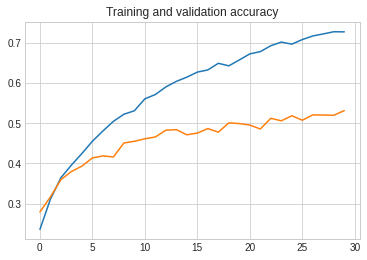

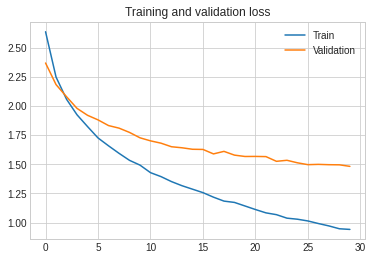

In [ ]:
plot_res(history)